<a href="https://colab.research.google.com/github/juanlurg/samsung-human-activity/blob/master/Samsung%20Human%20Activity%20EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


  # Samsung Human Activity Recognition EDA
In this notebook we are working with datasets from [UCI ML](https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones). It contains data from 30 study participants performing daily living activities like walking or going upstairs. The data comes from the accelerometers and gyroscopes of Samsung Galaxy S3. The final objective is **to classify the activities into one of the six activities** we are working on. 

For more information about the experiment please take a look at [UCI archives](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones), we will focus on the data side in two steps:
- **Performing EDA** (Exploratory Data Analysis)
- **Machine Learning and modeling**

As usual; we import the commonly used packages for data science in Python, in addition we are hidding some warnings to improve the readability of the notebook.

In [0]:
# To work with data
import pandas as pd

# Np and clustering
import numpy as np
from numpy import pi
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering

# Plotting
from matplotlib.colors import rgb2hex
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

# For distributions
from scipy.stats import norm, skew, probplot
from scipy.optimize import curve_fit

# For PCA and tSNE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

We can start loading the data, as we have it splitted in train and test after loading the files we are combining them in a full dataframe for exploratory purposes.

The next step is to take a look at shapes and why not; some data rows.

In [14]:
# Load datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Combine boths dataframes
train_df['Data'] = 'Train'
test_df['Data'] = 'Test'
full_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)
full_df['subject'] = '#' + full_df['subject'].astype(str)

# Look at the shape of dataframes
print('Shape Train: {}'.format(train_df.shape))
print('Shape Test: {}\n'.format(test_df.shape))
full_df.head()

Shape Train: (7352, 564)
Shape Test: (2947, 564)



,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,Data
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,-0.567378,-0.744413,0.852947,0.685845,0.814263,-0.965523,-0.999945,-0.999863,-0.994612,-0.994231,-0.987614,-0.943220,-0.407747,-0.679338,-0.602122,0.929294,-0.853011,0.359910,-0.058526,0.256892,-0.224848,0.264106,-0.095246,0.278851,-0.465085,0.491936,-0.190884,0.376314,0.435129,0.660790,...,-0.936508,0.346989,-0.516080,-0.802760,-0.980135,-0.961309,-0.973653,-0.952264,-0.989498,-0.980135,-0.999240,-0.992656,-0.701291,-1.000000,-0.128989,0.586156,0.374605,-0.991990,-0.990697,-0.989941,-0.992448,-0.991048,-0.991990,-0.999937,-0.990458,-0.871306,-1.000000,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,#1,STANDING,Train
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,-0.557851,-0.818409,0.849308,0.685845,0.822637,-0.981930,-0.999991,-0.999788,-0.998405,-0.999150,-0.977866,-0.948225,-0.714892,-0.500930,-0.570979,0.611627,-0.329549,0.284213,0.284595,0.115705,-0.090963,0.294310,-0.281211,0.085988,-0.022153,-0.016657,-0.220643,-0.013429,-0.072692,0.579382,...,-0.841270,0.532061,-0.624871,-0.900160,-0.988296,-0.983322,-0.982659,-0.986321,-0.991829,-0.988296,-0.999811,-0.993979,-0.720683,-0.948718,-0.271958,-0.336310,-0.720015,-0.995854,-0.996399,-0.995442,-0.996866,-0.994440,-0.995854,-0.999981,-0.994544,-1.000000,-1.000000,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,#1,STANDING,Train
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,-0.557851,-0.818409,0.843609,0.682401,0.839344,-0.983478,-0.999969,-0.999660,-0.999470,-0.997130,-0.964810,-0.974675,-0.592235,-0.485821,-0.570979,0.273025,-0.086309,0.337202,-0.164739,0.017150,-0.074507,0.342256,-0.332564,0.239281,-0.136204,0.173863,-0.299493,-0.124698,-0.181105,0.608900,...,-0.904762,0.660795,-0.724697,-0.928539,-0.989255,-0.986028,-0.984274,-0.990979,-0.995703,-0.989255,-0.999854,-0.993238,-0.736521,-0.794872,-0.212728,-0.53535

We can see that there are some acceleration and gyroscope information. Also some gravity features.

Let see the type of data we have and the number of nulls we can find into the data. 

In [0]:
# Dtype of the columns and no of nulls
full_df.info()
print("No. of nulls: {}".format(full_df.isna().sum().sum()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10299 entries, 0 to 10298
Columns: 564 entries, tBodyAcc-mean()-X to Data
dtypes: float64(561), object(3)
memory usage: 44.3+ MB
No. of nulls: 0


Our main aim is to categorize an activity in to one of the six we have, so let's take a look on how the label is distributed.

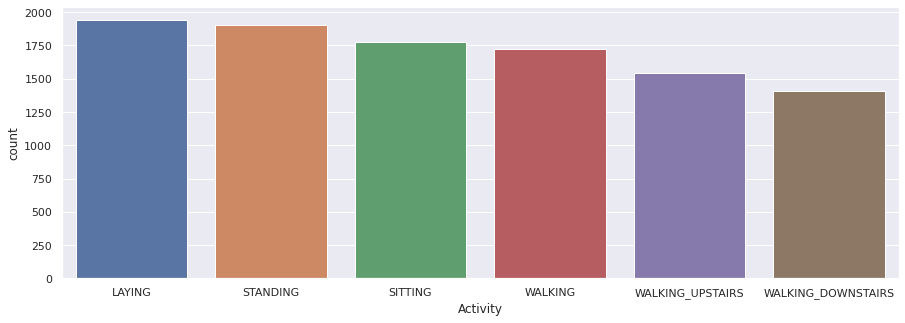

In [0]:
# Distribution of label
plt.figure(figsize=(15,5))
ax = sns.countplot(x='Activity', data=full_df, order=full_df['Activity'].value_counts().index)

They are not exactly equal but we can accept that the labels are quite equaly distributed, we don't have a very unbalanced dataset.

One curious thing we can see here is the fact that the count of WALKING_UPSTAIRS and WALKING_DOWNSTAIRS is not equal; the participants normally have to walk the same number of stairs down and up and the phone sampling is constant. **The only choice is that walk faster downstairs than upstairs**, so the phone has time to register more events when walking upstairs.

## Separability of the activities
As we are aiming to classify the activity based on sensors, we should investigate the **separability of the classes**.

For that we are going to use PCA (Principal Component Analysis) technique, used to reduce the dimensionality of a dataset. As we are using 0.9 as n_components this technique will **leave as many features as neccesary to explain at least the 90% of the variance** of the original dataset. 

What can we see in the result?

In [0]:
# Create label
label = full_df.pop('Activity')

# Create datasets
tsne_data = full_df.copy()
data_data = tsne_data.pop('Data')
subject_data = tsne_data.pop('subject')

# Scale data
scl = StandardScaler()
tsne_data = scl.fit_transform(tsne_data)

# Reduce dimensions (speed up)
pca = PCA(n_components=0.9, random_state=3)
tsne_data = pca.fit_transform(tsne_data)

# Transform data
tsne = TSNE(random_state=3)
tsne_transformed = tsne.fit_transform(tsne_data)

In [0]:
codes = label.astype('category').cat.codes
n_classes = np.unique(codes).size
label_counts = label.value_counts()

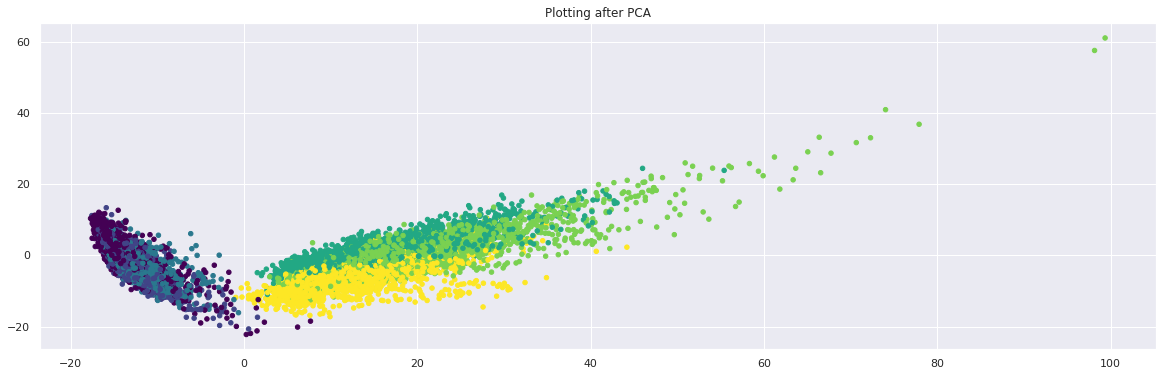

In [0]:
# Your code here  
plt.figure(figsize=(20,6))
plt.title("Plotting after PCA")
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=codes, s=20, cmap='viridis')

The conclusion we can have after this first approach into dimensionality reduction and data plotted is that **we could cluster the data into two groups** (following the chart above):

- Yellow, light green and darker green.
- Turquoise, light blue and blue.

Which activities does it mean?

- Walking, going upstairs, going downstairs.
- Sitting, standing, lying.

So our first insight is that **data is clearly different depending on if we have movement or not**. Logical, but cool to extract it from our data.

The next approach is to apply KMeans, a clustering method, to try to group our data, as number of clusters we are using the number of activities (as we would like to have one group for each activity).


In [0]:
kmeans = KMeans(n_clusters=n_classes, n_init=100, 
                random_state=17, n_jobs=1)
kmeans.fit(tsne_data)
cluster_labels = kmeans.labels_

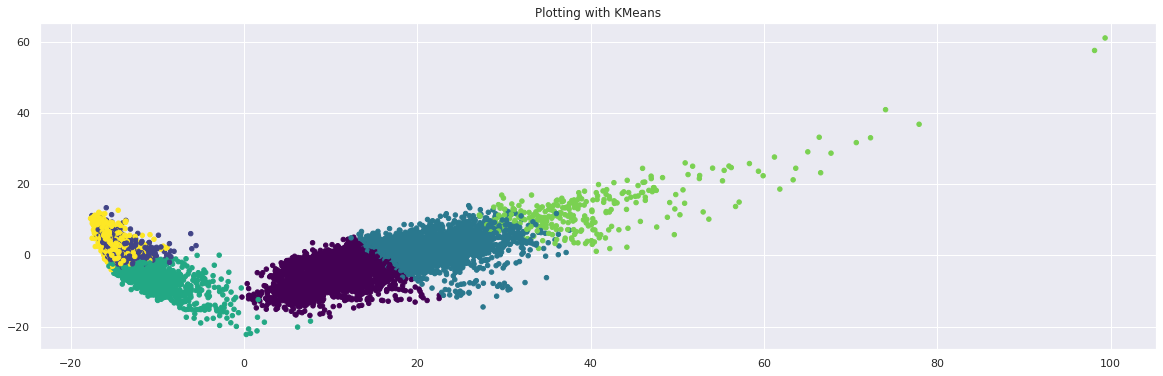

In [0]:
plt.figure(figsize=(20,6))
plt.title("Plotting with KMeans")
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=cluster_labels, s=20,  
            cmap='viridis')

Okay, it starts to get interesting. We have improved the way of "grouping" of our data. Let's look at the "borders" between classes so we can identify which activities confuse KMeans the most.

In [15]:
tab = pd.crosstab(codes, cluster_labels, margins=True)
tab.index = ['walking', 'going up the stairs',
            'going down the stairs', 'sitting', 'standing', 'lying', 'all']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['all']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,all
walking,5,52,0,329,0,1558,1944
going up the stairs,1,1235,0,450,0,91,1777
going down the stairs,0,1344,0,562,0,0,1906
sitting,903,0,741,0,78,0,1722
standing,320,0,890,0,196,0,1406
lying,1241,0,296,2,5,0,1544
all,2470,2631,1927,1343,279,1649,10299


As next step we will try with tSNE is a technique that help us to visualize high-dimesional data (like our case). Read more in the [sklearn docs](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). Let's see how our data looks when using this and let see how our classifiers score before doing machine learning.

In [0]:
# Transform data
tsne = TSNE(random_state=3)
tsne_transformed = tsne.fit_transform(tsne_data)

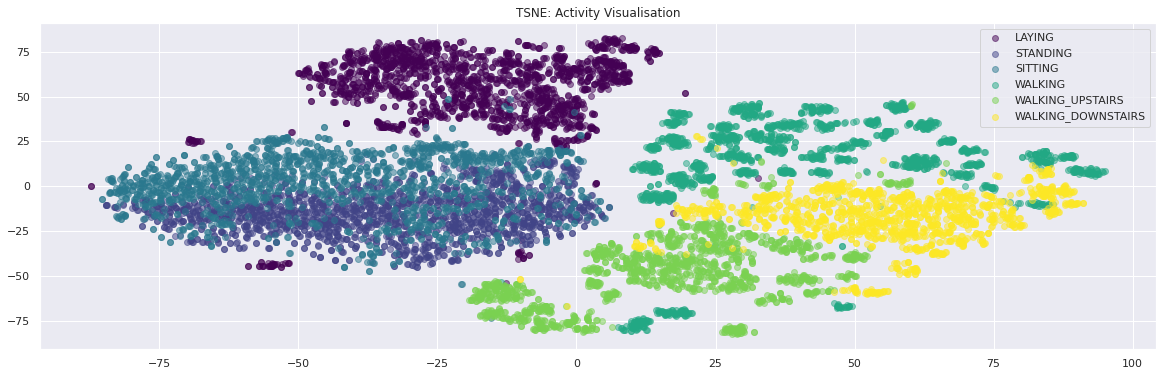

In [11]:
plt.figure(figsize=(20,6))
n = label.unique().shape[0]
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Plot each activity
for i, group in enumerate(label_counts.index):
    # Mask to separate sets
    mask = (label==group).values
    plt.scatter(x=tsne_transformed[mask][:,0], y=tsne_transformed[mask][:,1], c=colors[i], alpha=0.5, label=group)
plt.title('TSNE: Activity Visualisation')
plt.legend()

It seems that tSNE techinque has helped us to improve the way we are grouping our data but we still have some problems with sitting/standing.

A really interesting metric at this point would be to know which sensor is more relevant when detecting the activity. We will go trough this in the next notebook, as we will be doing some machine learning to model our data (and we will be able to use some algorithm's feature importance).